In [19]:
import math
import matplotlib.pyplot as plt
import operator
import torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [3]:
n_clusters = 6
n_samples = 250

In [4]:
centroids = torch.rand(n_clusters, 2) * 70 -35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [9]:
def sample(m):
  return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))

In [10]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [13]:
def plot_data(centroids, data, n_samples, ax=None):
  if ax is None: _, ax = plt.subplots()
  for i, centroid in enumerate(centroids):
    samples = data[i*n_samples:(i+1)*n_samples]
    ax.scatter(samples[:,0], samples[:,1], s=1)
    ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
    ax.plot(*centroid, markersize=5, marker='x', color='m', mew=2)

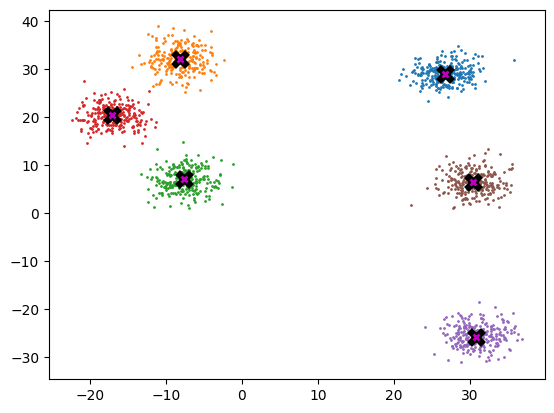

In [12]:
plot_data(centroids, data, n_samples)

In [21]:
def gaussian(d, bw):
  return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [22]:
def plot_fun(f):
  x = torch.linspace(0, 10, 100)
  plt.plot(x, f(x))

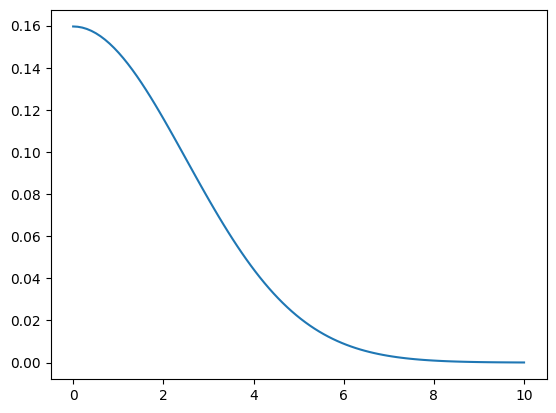

In [25]:
plot_fun(partial(gaussian, bw=2.5))

In [26]:
partial?

In [27]:
def tri(d, i):
  return (-d+i).clamp_min(0)/i

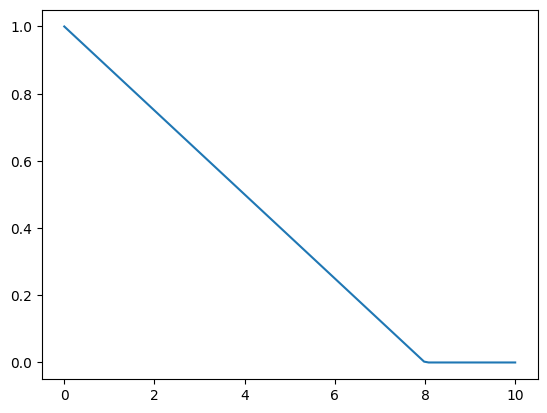

In [28]:
plot_fun(partial(tri, i=8))

In [29]:
X = data.clone()
x = data[0]

In [30]:
x

tensor([26.204, 26.349])

In [31]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [32]:
x-X[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [34]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [52]:
dist = torch.einsum("ij,ij->i", (x-X), (x-X)).sqrt()

In [53]:
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [54]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [55]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [58]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [59]:
def one_update(X):
  for i, x in enumerate(X):
    dist = torch.sqrt(((x-X)**2).sum(1))
    weight = gaussian(dist, 2.5)
    X[i] = (weight[:, None]*X).sum(0)/weight.sum()

In [60]:
def meanshift(data):
  X = data.clone()
  for it in range(5):
    one_update(X)
  return X

In [61]:
%time X=meanshift(data)

CPU times: user 1.43 s, sys: 5.14 ms, total: 1.43 s
Wall time: 1.44 s


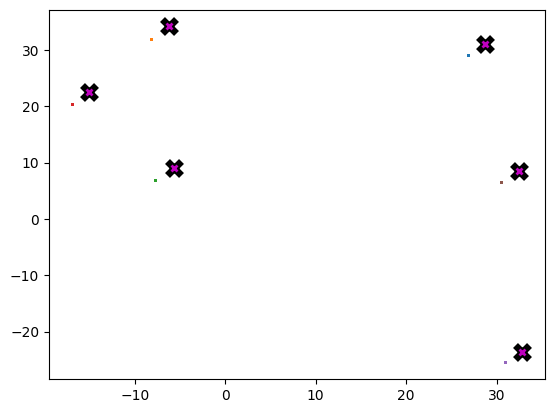

In [63]:
plot_data(centroids+2, X, n_samples)

In [64]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [65]:
def do_one(d):
  if not d:
    return plot_data(centroids+2, X, n_samples, ax=ax)
  one_update(X)
  ax.clear()
  plot_data(centroids+2, X, n_samples, ax=ax)


In [66]:
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())